In [65]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # <-- ADD THIS
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import os
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.20.0
GPU Available: False


In [66]:
# DATA ACQUISITION

print("=" * 60)
print("DATA ACQUISITION")
print("=" * 60)

# Load CIFAR-10 dataset (automatically downloads if not present)
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Class names: {class_names}")

DATA ACQUISITION

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


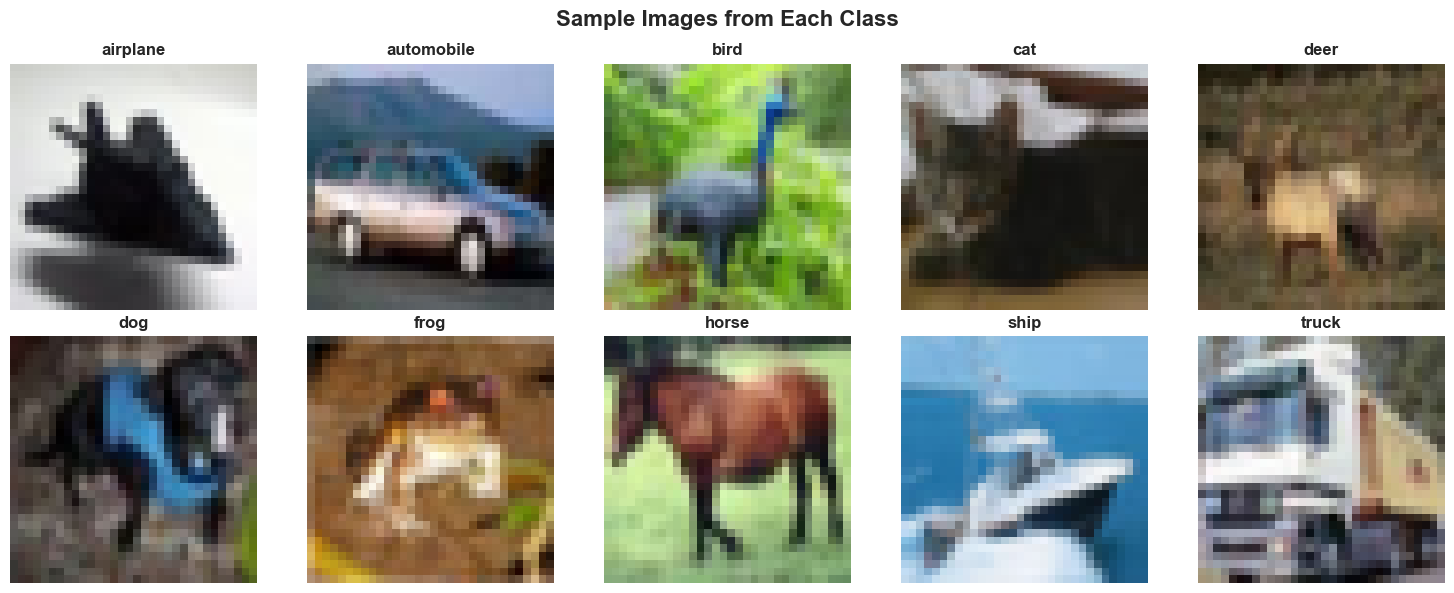


 Saved: visualization_sample_images.png


In [67]:
# 3. EXPLORATORY DATA ANALYSIS

# Visualization 1: Sample Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Get first image of each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx])
    ax.set_title(f'{class_names[i]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('visualization_sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: visualization_sample_images.png")



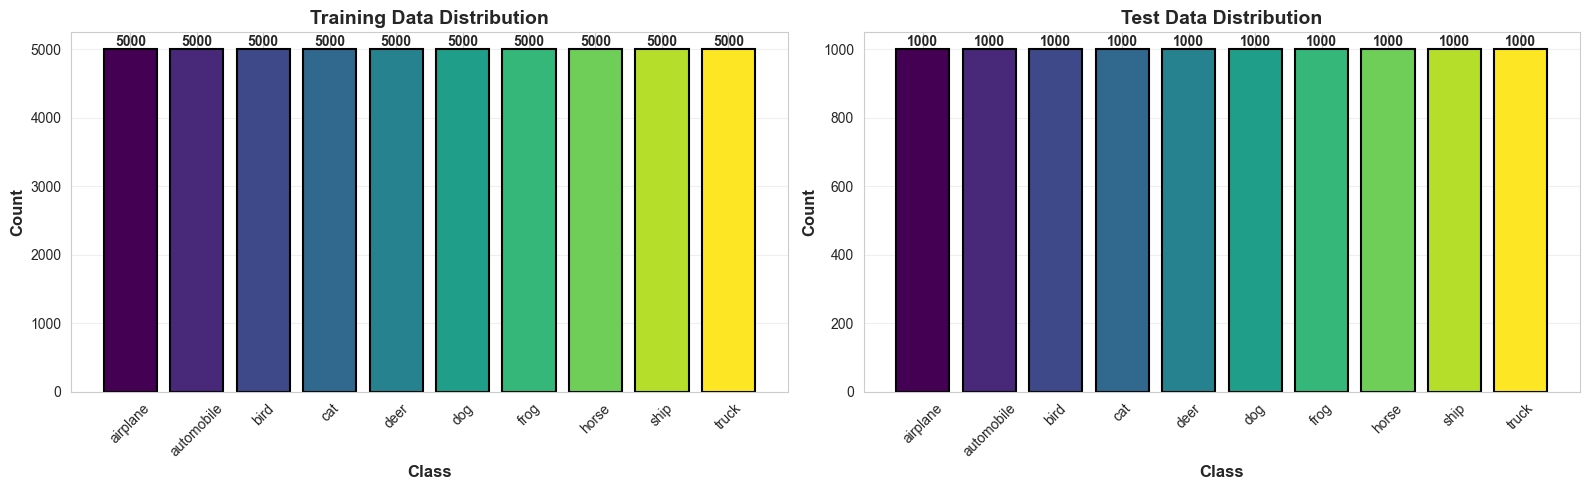

Saved: visualization_class_distribution.png

 Class Distribution Analysis:
Training samples per class: Min=5000, Max=5000
Test samples per class: Min=1000, Max=1000
 Dataset is perfectly balanced!


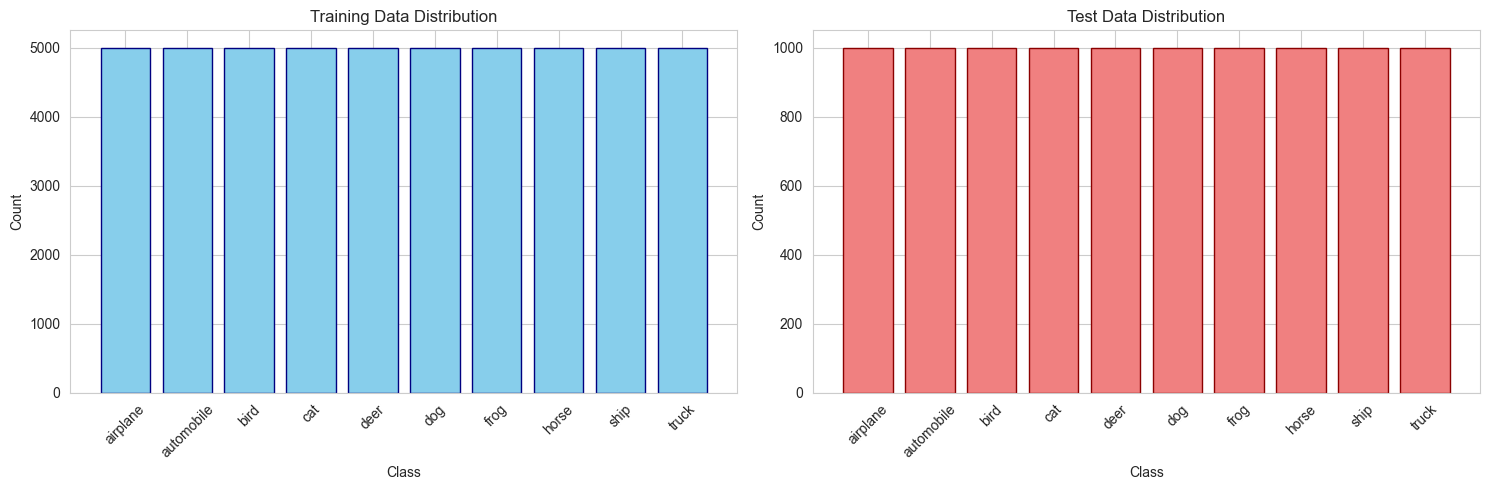

Training samples per class: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Test samples per class: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


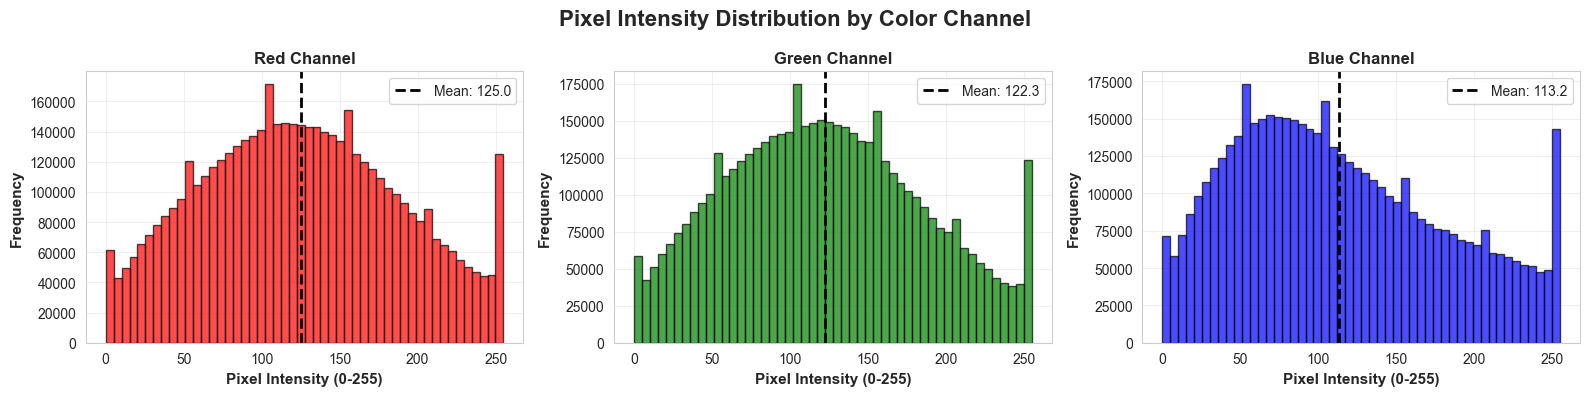

 Saved: visualization_pixel_intensity.png

 Pixel Intensity Analysis:
Red Channel - Mean: 125.31, Std: 62.99
Green Channel - Mean: 122.95, Std: 62.09
Blue Channel - Mean: 113.87, Std: 66.70


In [68]:
# Class Distribution Analysis

# Visualization 2: Class Distribution
train_counts = np.bincount(y_train.flatten())
test_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Training distribution
colors = plt.cm.viridis(np.linspace(0, 1, 10))
bars1 = ax1.bar(class_names, train_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Test distribution
bars2 = ax2.bar(class_names, test_counts, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Test Data Distribution', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: visualization_class_distribution.png")
print("\n Class Distribution Analysis:")
print(f"Training samples per class: Min={train_counts.min()}, Max={train_counts.max()}")
print(f"Test samples per class: Min={test_counts.min()}, Max={test_counts.max()}")
print(" Dataset is perfectly balanced!")
# Visualization 2: Class Distribution
train_class_counts = np.bincount(y_train.flatten())
test_class_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
ax1.bar(class_names, train_class_counts, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Training Data Distribution')
ax1.tick_params(axis='x', rotation=45)

# Test distribution
ax2.bar(class_names, test_class_counts, color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Test Data Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training samples per class: {train_class_counts}")
print(f"Test samples per class: {test_class_counts}")

#Pixel Intensity Analysis

# Visualization 3: Pixel Intensity Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Pixel Intensity Distribution by Color Channel', fontsize=16, fontweight='bold')

colors_channels = ['red', 'green', 'blue']
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']

# Sample 5000 images for analysis
sample_size = 5000
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[sample_indices]

for i, (ax, color, name) in enumerate(zip(axes, colors_channels, channel_names)):
    channel_data = X_sample[:, :, :, i].flatten()
    
    ax.hist(channel_data, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Pixel Intensity (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(channel_data)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.legend()

plt.tight_layout()
plt.savefig('visualization_pixel_intensity.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: visualization_pixel_intensity.png")
print("\n Pixel Intensity Analysis:")
for i, name in enumerate(['Red', 'Green', 'Blue']):
    channel_mean = np.mean(X_train[:, :, :, i])
    channel_std = np.std(X_train[:, :, :, i])
    print(f"{name} Channel - Mean: {channel_mean:.2f}, Std: {channel_std:.2f}")




In [69]:
# DATA PREPROCESSING

print("\n" + "=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"\nOriginal data range: [{X_train.min()}, {X_train.max()}]")
print(f"Normalized data range: [{X_train_normalized.min():.2f}, {X_train_normalized.max():.2f}]")

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"\nOriginal label shape: {y_train.shape}")
print(f"Categorical label shape: {y_train_cat.shape}")
print(" Labels converted to one-hot encoding")

# Data Augmentation
print("\n Configuring Data Augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print(" Data augmentation configured:")
print("   - Rotation: ±15 degrees")
print("   - Shift: 10% horizontal/vertical")
print("   - Horizontal flip: Yes")
print("   - Zoom: 10%")


DATA PREPROCESSING

Original data range: [0, 255]
Normalized data range: [0.00, 1.00]

Original label shape: (50000, 1)
Categorical label shape: (50000, 10)
 Labels converted to one-hot encoding

 Configuring Data Augmentation...
 Data augmentation configured:
   - Rotation: ±15 degrees
   - Shift: 10% horizontal/vertical
   - Horizontal flip: Yes
   - Zoom: 10%


In [70]:
# MODEL CREATION 

print("\n" + "=" * 60)
print("MODEL CREATION")
print("=" * 60)

def create_model(input_shape=(32, 32, 3), num_classes=10):
    """Create improved CNN model for CIFAR-10"""
    
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='CIFAR10_CNN')
    
    return model

# Create model
model = create_model()

# Display model summary
print("\n Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\n Model Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL CREATION

 Model Architecture:


Model: "CIFAR10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,662,730 (10.16 MB)

 Trainable params: 2,660,426 (10.15 MB)

 Non-trainable params: 2,304 (9.00 KB)


 Model Parameters:
Total parameters: 2,662,730
Trainable parameters: 2,660,426


In [71]:
# MODEL COMPILATION & CALLBACKS

print("\n" + "=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with:")
print(f"   - Optimizer: Adam (lr=0.001)")
print(f"   - Loss: Categorical Crossentropy")
print(f"   - Metrics: Accuracy")

# Setup callbacks - PUT IT HERE
os.makedirs('models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n Callbacks configured:")
print("   - Early Stopping (patience=15)")
print("   - Model Checkpoint (save best)")
print("   - Learning Rate Reduction (patience=5)")


MODEL COMPILATION
Model compiled with:
   - Optimizer: Adam (lr=0.001)
   - Loss: Categorical Crossentropy
   - Metrics: Accuracy

 Callbacks configured:
   - Early Stopping (patience=15)
   - Model Checkpoint (save best)
   - Learning Rate Reduction (patience=5)


In [72]:
# MODEL TRAINING

print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

batch_size = 64  
epochs = 50      

print(f"\n Training Configuration:")
print(f"   - Batch size: {batch_size}")
print(f"   - Epochs: {epochs}")
print(f"   - Training samples: {len(X_train_normalized)}")
print(f"   - Validation samples: {len(X_test_normalized)}")

print("\n Starting training...")
print("=" * 60)

# Train model
history = model.fit(
    datagen.flow(X_train_normalized, y_train_cat, batch_size=batch_size),
    steps_per_epoch=len(X_train_normalized) // batch_size,
    epochs=epochs,
    validation_data=(X_test_normalized, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")

# Save history
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved")


MODEL TRAINING

 Training Configuration:
   - Batch size: 64
   - Epochs: 50
   - Training samples: 50000
   - Validation samples: 10000

 Starting training...
Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.3570 - loss: 2.0816
Epoch 1: val_accuracy improved from None to 0.53110, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 724s 903ms/step - accuracy: 0.4388 - loss: 1.6798 - val_accuracy: 0.5311 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:20 718ms/step - accuracy: 0.4844 - loss: 1.3067

c:\Users\Hp\Documents\as\MLOP_Summative\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.53110
781/781 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.4844 - loss: 1.3067 - val_accuracy: 0.5283 - val_loss: 1.3428 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.5769 - loss: 1.1849
Epoch 3: val_accuracy improved from 0.53110 to 0.62300, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 734s 939ms/step - accuracy: 0.6024 - loss: 1.1162 - val_accuracy: 0.6230 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 4/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:29 807ms/step - accuracy: 0.6250 - loss: 0.8489
Epoch 4: val_accuracy did not improve from 0.62300
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.6250 - loss: 0.8489 - val_accuracy: 0.6190 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.6551 - loss: 0.9716
Epoch 5: val_accuracy improved from 0.62300 to 0.67290, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 659s 843ms/step - accuracy: 0.6629 - loss: 0.9546 - val_accuracy: 0.6729 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 6/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:20 718ms/step - accuracy: 0.6562 - loss: 0.9446
Epoch 6: val_accuracy did not improve from 0.67290
781/781 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.6562 - loss: 0.9446 - val_accuracy: 0.6716 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.6917 - loss: 0.8828
Epoch 7: val_accuracy improved from 0.67290 to 0.73230, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 619s 793ms/step - accuracy: 0.6926 - loss: 0.8773 - val_accuracy: 0.7323 - val_loss: 0.7731 - learning_rate: 0.0010
Epoch 8/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:03 697ms/step - accuracy: 0.6875 - loss: 1.0055
Epoch 8: val_accuracy did not improve from 0.73230
781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6875 - loss: 1.0055 - val_accuracy: 0.7305 - val_loss: 0.7712 - learning_rate: 0.0010
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7070 - loss: 0.8326
Epoch 9: val_accuracy improved from 0.73230 to 0.74500, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 598s 766ms/step - accuracy: 0.7139 - loss: 0.8171 - val_accuracy: 0.7450 - val_loss: 0.7504 - learning_rate: 0.0010
Epoch 10/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:11 707ms/step - accuracy: 0.6875 - loss: 0.8040
Epoch 10: val_accuracy did not improve from 0.74500
781/781 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.6875 - loss: 0.8040 - val_accuracy: 0.7433 - val_loss: 0.7571 - learning_rate: 0.0010
Epoch 11/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.7347 - loss: 0.7581
Epoch 11: val_accuracy did not improve from 0.74500
781/781 ━━━━━━━━━━━━━━━━━━━━ 728s 932ms/step - accuracy: 0.7350 - loss: 0.7591 - val_accuracy: 0.7236 - val_loss: 0.8458 - learning_rate: 0.0010
Epoch 12/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:04 852ms/step - accuracy: 0.7500 - loss: 0.6190
Epoch 12: val_accuracy did not improve from 0.74500
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7500 - loss: 0.6190 - val_accuracy: 0.7160 - val_loss: 0.8806 - learning_rate: 0.0

781/781 ━━━━━━━━━━━━━━━━━━━━ 700s 896ms/step - accuracy: 0.7481 - loss: 0.7266 - val_accuracy: 0.7951 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 14/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:47 907ms/step - accuracy: 0.7812 - loss: 0.6293
Epoch 14: val_accuracy did not improve from 0.79510
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7812 - loss: 0.6293 - val_accuracy: 0.7922 - val_loss: 0.5971 - learning_rate: 0.0010
Epoch 15/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.7582 - loss: 0.6975
Epoch 15: val_accuracy did not improve from 0.79510
781/781 ━━━━━━━━━━━━━━━━━━━━ 704s 901ms/step - accuracy: 0.7612 - loss: 0.6875 - val_accuracy: 0.7845 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 16/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:26 956ms/step - accuracy: 0.7656 - loss: 0.6506
Epoch 16: val_accuracy did not improve from 0.79510
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7656 - loss: 0.6506 - val_accuracy: 0.7836 - val_loss: 0.6473 - learning_rate: 0.

781/781 ━━━━━━━━━━━━━━━━━━━━ 719s 920ms/step - accuracy: 0.7969 - loss: 0.5871 - val_accuracy: 0.8144 - val_loss: 0.5512 - learning_rate: 5.0000e-04
Epoch 20/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:15 943ms/step - accuracy: 0.8438 - loss: 0.5040
Epoch 20: val_accuracy did not improve from 0.81440
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8438 - loss: 0.5040 - val_accuracy: 0.8120 - val_loss: 0.5571 - learning_rate: 5.0000e-04
Epoch 21/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8059 - loss: 0.5561
Epoch 21: val_accuracy did not improve from 0.81440
781/781 ━━━━━━━━━━━━━━━━━━━━ 696s 890ms/step - accuracy: 0.8065 - loss: 0.5601 - val_accuracy: 0.8076 - val_loss: 0.5723 - learning_rate: 5.0000e-04
Epoch 22/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:28 960ms/step - accuracy: 0.7031 - loss: 0.7457
Epoch 22: val_accuracy did not improve from 0.81440
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.7031 - loss: 0.7457 - val_accuracy: 0.8085 - val_loss: 0.5703 - learn

781/781 ━━━━━━━━━━━━━━━━━━━━ 729s 933ms/step - accuracy: 0.8140 - loss: 0.5394 - val_accuracy: 0.8299 - val_loss: 0.5014 - learning_rate: 5.0000e-04
Epoch 24/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 13:10 1s/step - accuracy: 0.8281 - loss: 0.4933
Epoch 24: val_accuracy improved from 0.82990 to 0.83030, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.8281 - loss: 0.4933 - val_accuracy: 0.8303 - val_loss: 0.4999 - learning_rate: 5.0000e-04
Epoch 25/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.8227 - loss: 0.5193
Epoch 25: val_accuracy did not improve from 0.83030
781/781 ━━━━━━━━━━━━━━━━━━━━ 723s 926ms/step - accuracy: 0.8185 - loss: 0.5273 - val_accuracy: 0.8149 - val_loss: 0.5573 - learning_rate: 5.0000e-04
Epoch 26/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 19:30 2s/step - accuracy: 0.8281 - loss: 0.4659
Epoch 26: val_accuracy did not improve from 0.83030
781/781 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.8281 - loss: 0.4659 - val_accuracy: 0.8158 - val_loss: 0.5529 - learning_rate: 5.0000e-04
Epoch 27/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.8209 - loss: 0.5211
Epoch 27: val_accuracy did not improve from 0.83030
781/781 ━━━━━━━━━━━━━━━━━━━━ 726s 929ms/step - accuracy: 0.8201 - loss: 0.5206 - val_accuracy: 0.8200 - val_loss: 0.5144 - learning_ra

781/781 ━━━━━━━━━━━━━━━━━━━━ 738s 944ms/step - accuracy: 0.8235 - loss: 0.5101 - val_accuracy: 0.8371 - val_loss: 0.4843 - learning_rate: 5.0000e-04
Epoch 30/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 13:06 1s/step - accuracy: 0.8594 - loss: 0.4182
Epoch 30: val_accuracy improved from 0.83710 to 0.83770, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8594 - loss: 0.4182 - val_accuracy: 0.8377 - val_loss: 0.4825 - learning_rate: 5.0000e-04
Epoch 31/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.8284 - loss: 0.4908
Epoch 31: val_accuracy improved from 0.83770 to 0.83960, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 710s 908ms/step - accuracy: 0.8292 - loss: 0.4903 - val_accuracy: 0.8396 - val_loss: 0.4650 - learning_rate: 5.0000e-04
Epoch 32/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:15 943ms/step - accuracy: 0.8281 - loss: 0.4583
Epoch 32: val_accuracy did not improve from 0.83960
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8281 - loss: 0.4583 - val_accuracy: 0.8377 - val_loss: 0.4708 - learning_rate: 5.0000e-04
Epoch 33/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.8326 - loss: 0.4829
Epoch 33: val_accuracy improved from 0.83960 to 0.84840, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 708s 907ms/step - accuracy: 0.8314 - loss: 0.4865 - val_accuracy: 0.8484 - val_loss: 0.4438 - learning_rate: 5.0000e-04
Epoch 34/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:33 966ms/step - accuracy: 0.8125 - loss: 0.4256
Epoch 34: val_accuracy did not improve from 0.84840
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8125 - loss: 0.4256 - val_accuracy: 0.8472 - val_loss: 0.4478 - learning_rate: 5.0000e-04
Epoch 35/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8367 - loss: 0.4709
Epoch 35: val_accuracy improved from 0.84840 to 0.85640, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 719s 920ms/step - accuracy: 0.8344 - loss: 0.4791 - val_accuracy: 0.8564 - val_loss: 0.4235 - learning_rate: 5.0000e-04
Epoch 36/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:36 970ms/step - accuracy: 0.8438 - loss: 0.5177
Epoch 36: val_accuracy improved from 0.85640 to 0.85670, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8438 - loss: 0.5177 - val_accuracy: 0.8567 - val_loss: 0.4196 - learning_rate: 5.0000e-04
Epoch 37/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8420 - loss: 0.4540
Epoch 37: val_accuracy did not improve from 0.85670
781/781 ━━━━━━━━━━━━━━━━━━━━ 706s 904ms/step - accuracy: 0.8399 - loss: 0.4628 - val_accuracy: 0.8461 - val_loss: 0.4590 - learning_rate: 5.0000e-04
Epoch 38/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:30 885ms/step - accuracy: 0.7656 - loss: 0.4675
Epoch 38: val_accuracy did not improve from 0.85670
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7656 - loss: 0.4675 - val_accuracy: 0.8454 - val_loss: 0.4627 - learning_rate: 5.0000e-04
Epoch 39/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8427 - loss: 0.4541
Epoch 39: val_accuracy did not improve from 0.85670
781/781 ━━━━━━━━━━━━━━━━━━━━ 718s 919ms/step - accuracy: 0.8413 - loss: 0.4598 - val_accuracy: 0.8443 - val_loss: 0.4564 - learning

781/781 ━━━━━━━━━━━━━━━━━━━━ 907s 1s/step - accuracy: 0.8515 - loss: 0.4254 - val_accuracy: 0.8664 - val_loss: 0.3821 - learning_rate: 2.5000e-04
Epoch 44/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 13:26 1s/step - accuracy: 0.8906 - loss: 0.3178
Epoch 44: val_accuracy did not improve from 0.86640
781/781 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.8906 - loss: 0.3178 - val_accuracy: 0.8659 - val_loss: 0.3847 - learning_rate: 2.5000e-04
Epoch 45/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8558 - loss: 0.4120
Epoch 45: val_accuracy improved from 0.86640 to 0.87200, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 729s 934ms/step - accuracy: 0.8569 - loss: 0.4102 - val_accuracy: 0.8720 - val_loss: 0.3707 - learning_rate: 2.5000e-04
Epoch 46/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:30 885ms/step - accuracy: 0.7812 - loss: 0.6164
Epoch 46: val_accuracy improved from 0.87200 to 0.87260, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.7812 - loss: 0.6164 - val_accuracy: 0.8726 - val_loss: 0.3713 - learning_rate: 2.5000e-04
Epoch 47/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8589 - loss: 0.4095
Epoch 47: val_accuracy did not improve from 0.87260
781/781 ━━━━━━━━━━━━━━━━━━━━ 714s 915ms/step - accuracy: 0.8584 - loss: 0.4071 - val_accuracy: 0.8520 - val_loss: 0.4497 - learning_rate: 2.5000e-04
Epoch 48/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:39 973ms/step - accuracy: 0.8438 - loss: 0.5717
Epoch 48: val_accuracy did not improve from 0.87260
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8438 - loss: 0.5717 - val_accuracy: 0.8503 - val_loss: 0.4522 - learning_rate: 2.5000e-04
Epoch 49/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.8642 - loss: 0.3964
Epoch 49: val_accuracy improved from 0.87260 to 0.87500, saving model to models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 710s 909ms/step - accuracy: 0.8619 - loss: 0.3983 - val_accuracy: 0.8750 - val_loss: 0.3705 - learning_rate: 2.5000e-04
Epoch 50/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:00 923ms/step - accuracy: 0.8594 - loss: 0.4099
Epoch 50: val_accuracy did not improve from 0.87500
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8594 - loss: 0.4099 - val_accuracy: 0.8749 - val_loss: 0.3701 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 50.

 Training completed!
Training history saved



TRAINING VISUALIZATION


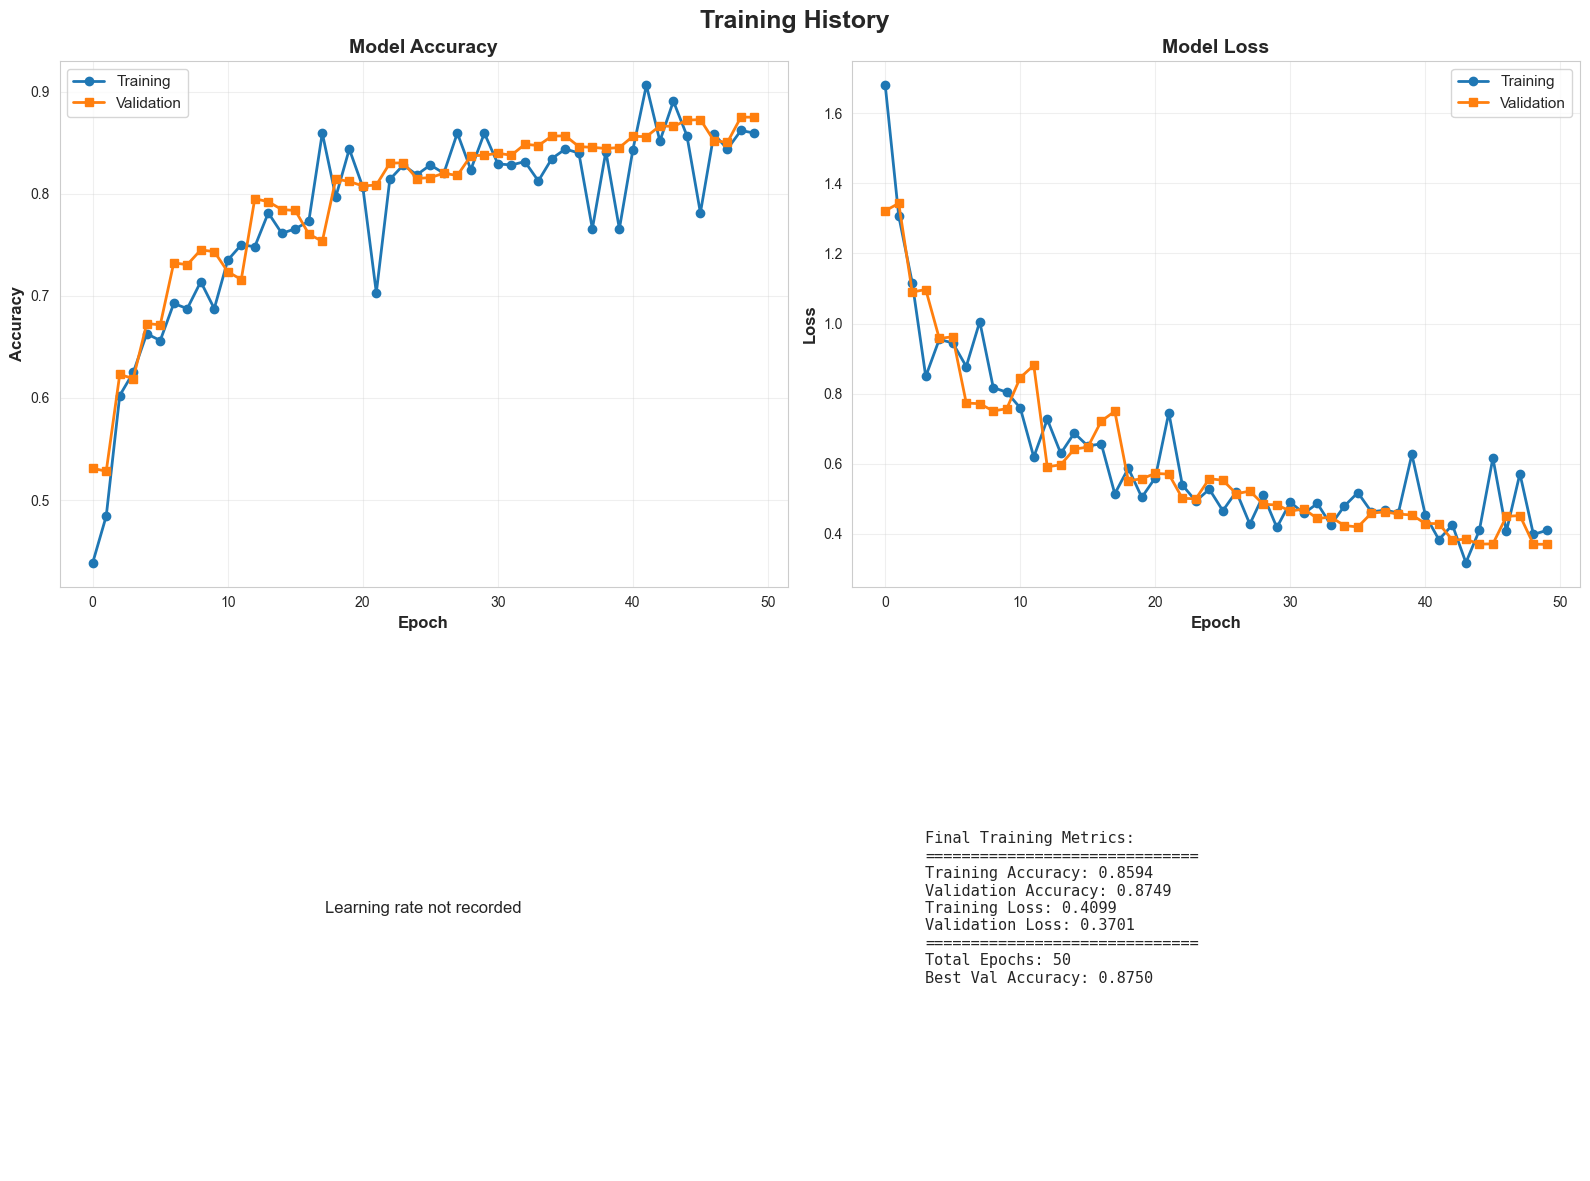

 Saved: training_history.png


In [73]:
# TRAINING VISUALIZATION

print("\n" + "=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training History', fontsize=18, fontweight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2, marker='o')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2, marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, marker='o', color='orange')
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate not recorded', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

summary_text = f"""
Final Training Metrics:
{'='*30}
Training Accuracy: {final_train_acc:.4f}
Validation Accuracy: {final_val_acc:.4f}
Training Loss: {final_train_loss:.4f}
Validation Loss: {final_val_loss:.4f}
{'='*30}
Total Epochs: {len(history.history['accuracy'])}
Best Val Accuracy: {max(history.history['val_accuracy']):.4f}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: training_history.png")


=== MODEL EVALUATION ===

 Making predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step

FINAL MODEL PERFORMANCE METRICS
Accuracy:  0.8749 (87.49%)
Precision: 0.8778 (87.78%)
Recall:    0.8749 (87.49%)
F1-Score:  0.8734 (87.34%)

 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.89      0.89      1000
  automobile       0.96      0.93      0.95      1000
        bird       0.87      0.81      0.84      1000
         cat       0.82      0.70      0.76      1000
        deer       0.85      0.88      0.86      1000
         dog       0.91      0.73      0.81      1000
        frog       0.77      0.97      0.86      1000
       horse       0.90      0.92      0.91      1000
        ship       0.93      0.94      0.94      1000
       truck       0.86      0.96      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg    

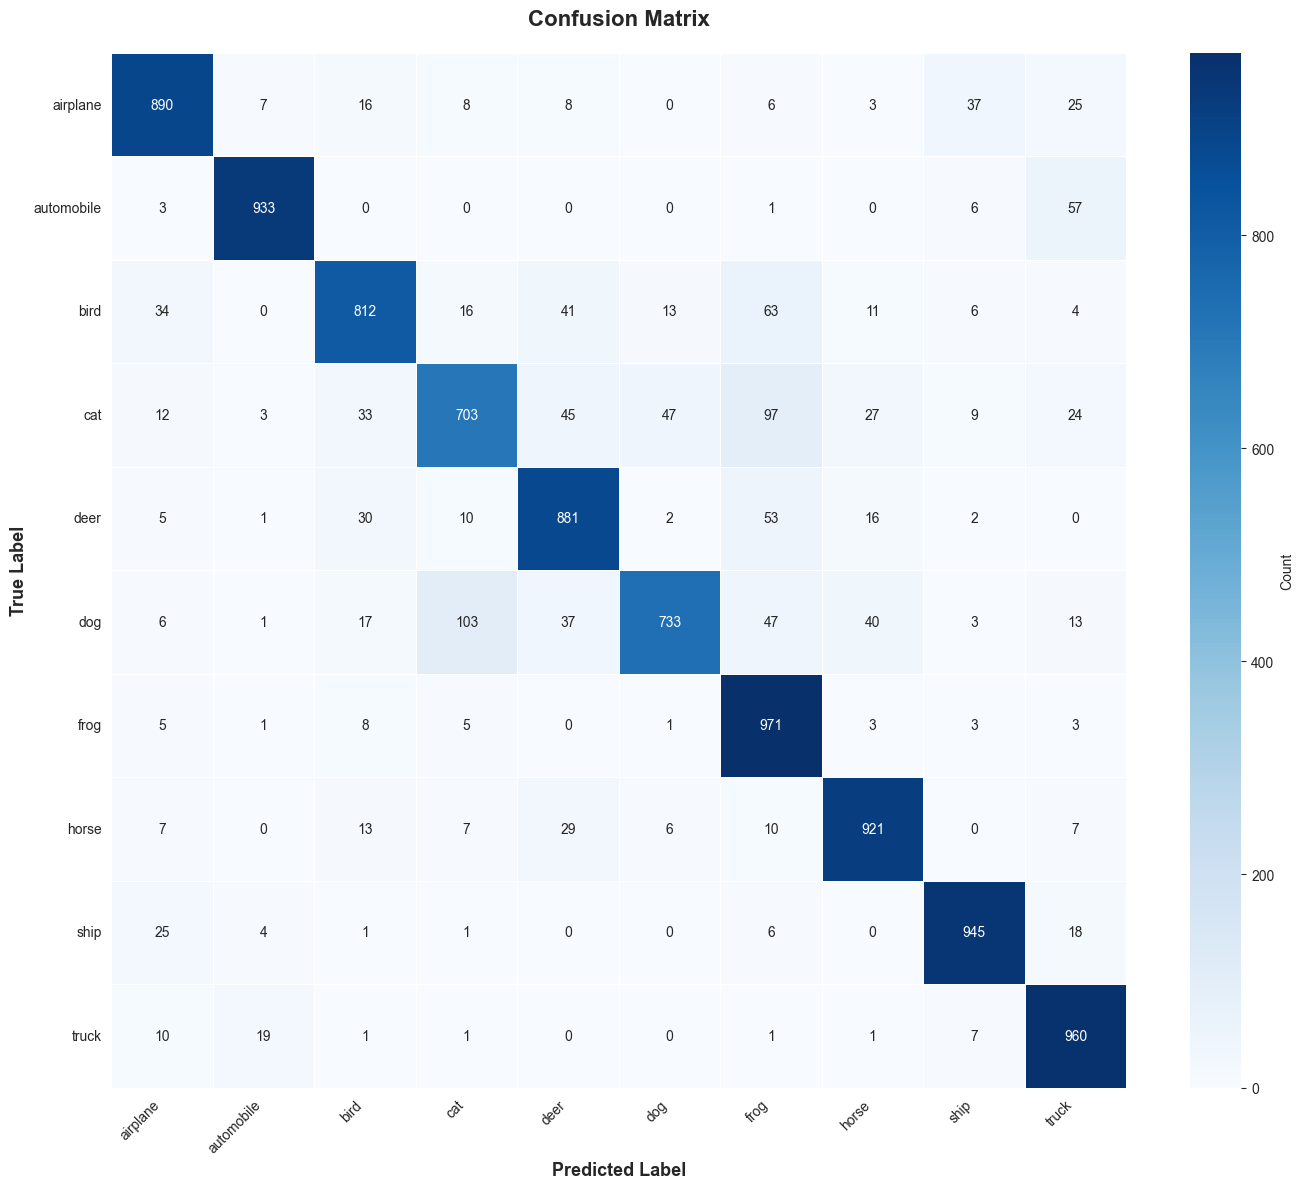

 Saved: confusion_matrix.png


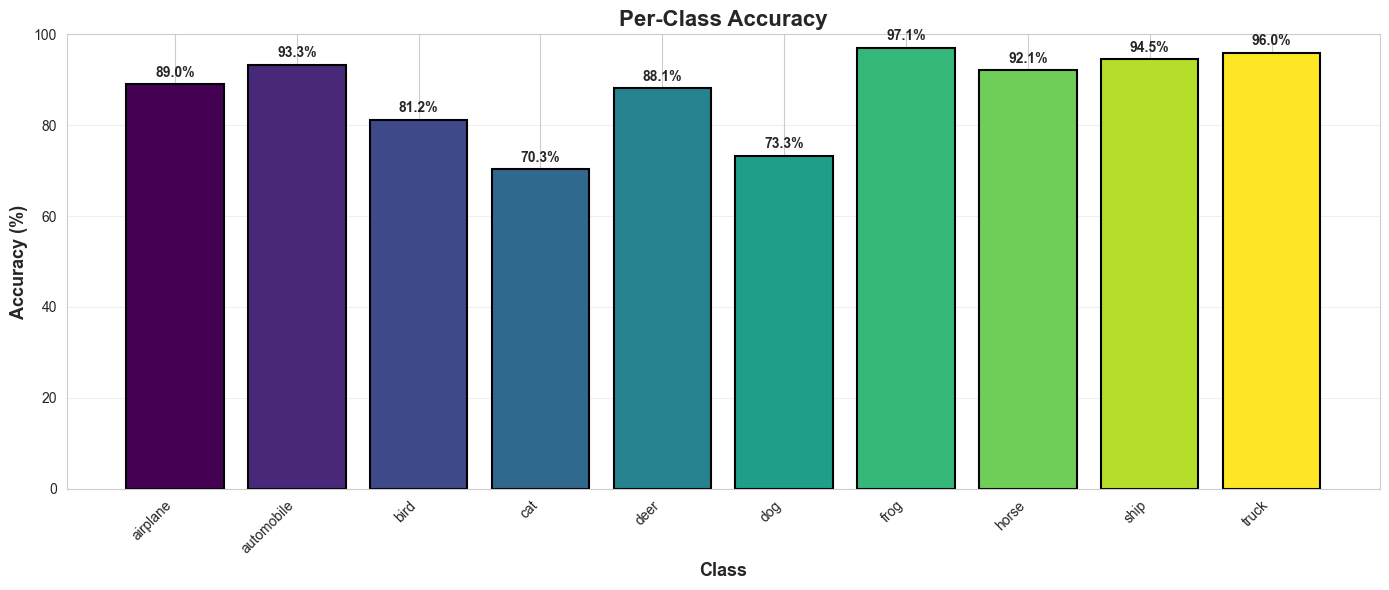

Saved: per_class_accuracy.png

 Per-Class Performance:
airplane    : 89.00%
automobile  : 93.30%
bird        : 81.20%
cat         : 70.30%
deer        : 88.10%
dog         : 73.30%
frog        : 97.10%
horse       : 92.10%
ship        : 94.50%
truck       : 96.00%


In [74]:
# MODEL EVALUATION

print("\n=== MODEL EVALUATION ===")

# Make predictions
print("\n Making predictions on test set...")
y_pred_probs = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("=" * 60)

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#  Confusion Matrix
print("\n Creating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix.png")

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy * 100, 
               color=plt.cm.viridis(np.linspace(0, 1, 10)),
               edgecolor='black', linewidth=1.5)
plt.xlabel('Class', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: per_class_accuracy.png")

print("\n Per-Class Performance:")
for i, name in enumerate(class_names):
    print(f"{name:12s}: {class_accuracy[i]*100:.2f}%")

In [75]:
# SAVE MODEL 

print("\n" + "=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save in H5 format (this is enough for the project)
model_h5_path = 'models/cifar10_classifier.h5'
model.save(model_h5_path)
print(f"Saved H5 model: {model_h5_path}")

# Save metadata
metadata = {
    'class_names': class_names,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_params': int(total_params),
    'trainable_params': int(trainable_params)
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Saved model metadata")

print("\n Files created:")
print(f"   - {model_h5_path}")
print(f"   - models/model_metadata.pkl")
print(f"   - models/training_history.pkl")


SAVING MODEL
Saved H5 model: models/cifar10_classifier.h5
Saved model metadata

 Files created:
   - models/cifar10_classifier.h5
   - models/model_metadata.pkl
   - models/training_history.pkl



TESTING PREDICTION FUNCTION

 Testing predictions on random test images:



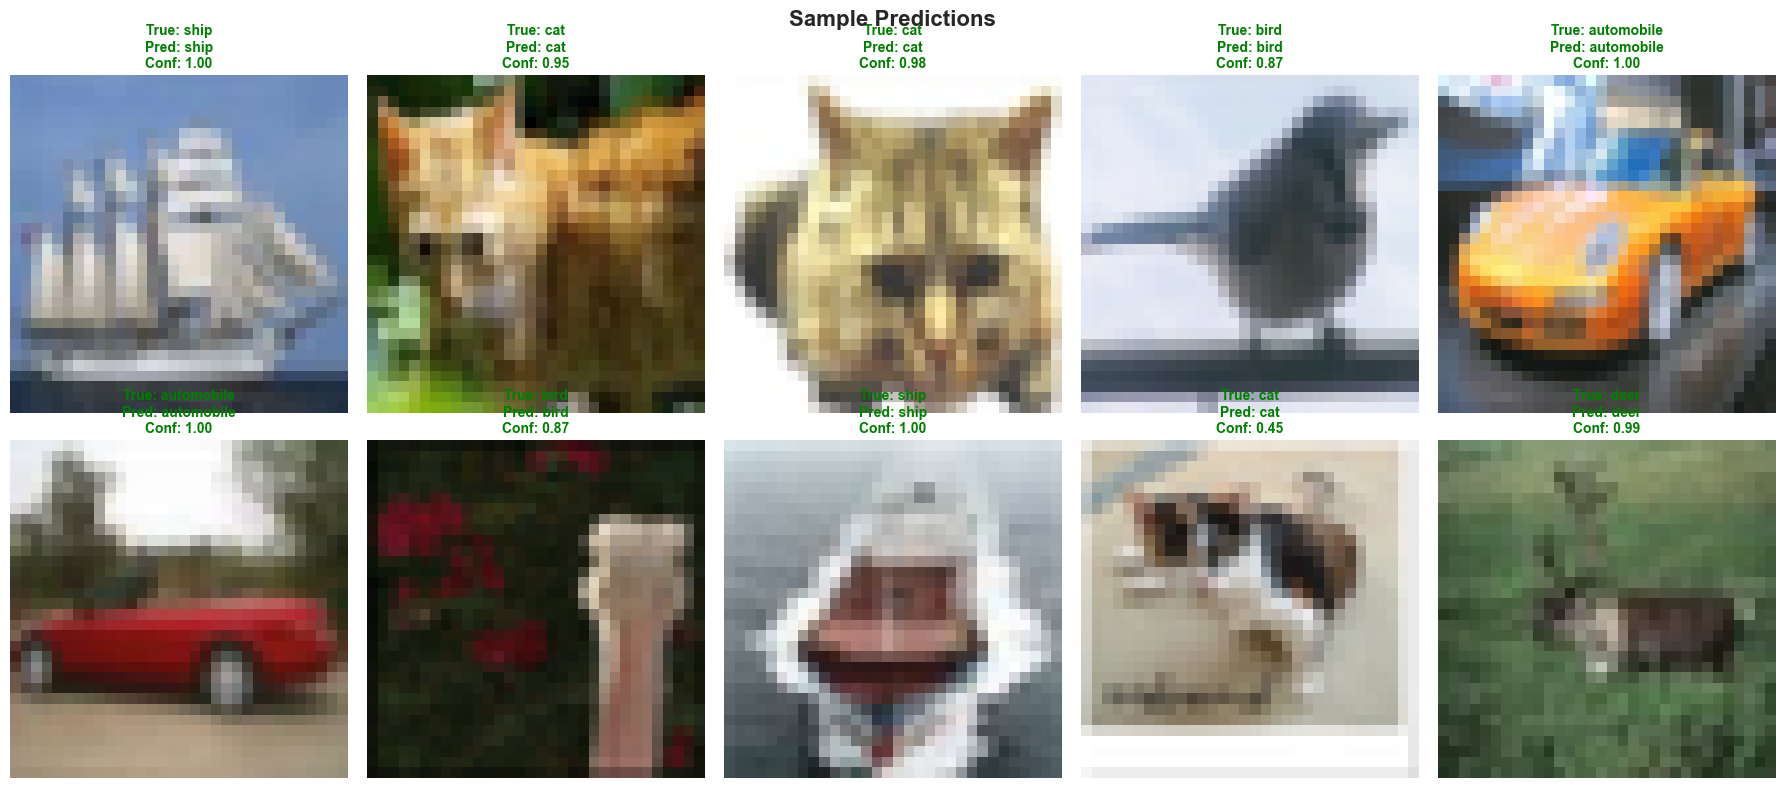

 Saved: sample_predictions.png

 Final Results:
   - Accuracy: 87.49%
   - Precision: 87.78%
   - Recall: 87.49%
   - F1-Score: 87.34%


In [76]:
# TEST PREDICTION FUNCTION

print("\n" + "=" * 60)
print("TESTING PREDICTION FUNCTION")
print("=" * 60)

def predict_image(model, image, class_names):
    """Predict class of a single image"""
    if image.shape != (32, 32, 3):
        raise ValueError(f"Image must be (32,32,3), got {image.shape}")
    
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch, verbose=0)
    
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    
    all_predictions = [
        {'class': class_names[i], 'confidence': float(predictions[0][i])}
        for i in range(len(class_names))
    ]
    all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {
        'predicted_class': class_names[predicted_idx],
        'confidence': float(confidence),
        'all_predictions': all_predictions
    }

# Test on random images
print("\n Testing predictions on random test images:\n")

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test_normalized))
    test_image = X_test_normalized[idx]
    true_label = class_names[y_test[idx][0]]
    
    result = predict_image(model, test_image, class_names)
    pred_label = result['predicted_class']
    confidence = result['confidence']
    
    ax.imshow(X_test[idx])
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: sample_predictions.png")

print("\n Final Results:")
print(f"   - Accuracy: {accuracy*100:.2f}%")
print(f"   - Precision: {precision*100:.2f}%")
print(f"   - Recall: {recall*100:.2f}%")
print(f"   - F1-Score: {f1*100:.2f}%")
